# TP : Sentiment analysis on IMDB movie reviews

## Júlia Togashi de Miranda

## Objectives:

1. Use a simple way to represent textual data - Bag of words
2. Test it with a simple model for a sentiment classification task - Naïve Bayesian
3. Explore improvements to these simple representations
4. Implement various methods to obtain dense representations (word embeddings) of the same data
5. Test these new representations with a simple classification model

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [317]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [318]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

"""
test_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'test', 'neg', '*.txt')))
test_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'test', 'pos', '*.txt')))
"""

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

"""
test_texts_neg = [open(f, encoding="utf8").read() for f in test_filenames_neg]
test_texts_pos = [open(f, encoding="utf8").read() for f in test_filenames_pos]
test_texts = test_texts_neg + test_texts_pos
"""

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.

"""
test_labels = np.ones(len(test_texts), dtype=np.int)
test_labels[:len(test_texts_neg)] = 0.
"""

'\ntest_labels = np.ones(len(test_texts), dtype=np.int)\ntest_labels[:len(test_texts_neg)] = 0.\n'

Example of one document:

In [319]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [320]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [321]:
from sklearn.model_selection import train_test_split

In [322]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

## Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [323]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]], dtype=int64)

Careful: check the memory that the representations are going to use (given the way they are build). What ```CountVectorizer``` argument allows to avoid the issue ? 

<blockquote>The possible problem is due to the fact that CountVectorizer builds a vocabulary that consider the top max_features ordered by term frequency across the corpus. If the number of words is really large and diverse, the generated vocabulary might exceed the capacity of the memory.  This problem can be prevented using the <b>max_features</b> parameter, which limit the memory usage of your vocabulary.</blockquote>

In [92]:
# Create and fit the vectorizer to the training data
train_bow = vectorizer.fit_transform(train_texts_splt)

print(vectorizer.get_feature_names())
train_bow.toarray()

['00', '000', '00001', '007', '0079', '0080', '0083', '01', '02', '05', '06', '07', '08', '09', '10', '100', '1000', '1000000', '100m', '101', '102', '103', '105', '10mil', '10th', '10yr', '11', '110', '1100', '11001001', '112', '12', '120', '1200f', '125', '12s', '12th', '13', '130', '134', '13th', '14', '145', '147', '14ieme', '14th', '15', '150', '16', '161', '16th', '16ème', '17', '1700', '1794', '1798', '18', '180', '1800', '1814', '1824', '1840', '1840s', '1850', '1864', '1880', '1880s', '1892', '1895', '1897', '18th', '19', '1902', '1907', '1910', '1911', '1912', '1914', '1916', '1918', '1920', '1920s', '1921', '1922', '1925', '1927', '1928', '1929', '1930', '1930s', '1931', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1950s', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1960s', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [93]:
print(train_bow.shape)

(2000, 25698)


In [94]:
# Transform the validation data
val_bow = vectorizer.transform(val_texts)

print(val_bow.shape)
val_bow.toarray()

(500, 25698)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

We are going to use the scikit-learn ```MultinomialNB```, an implementation of the Naive Bayesian model. Here, what is the naïve hypothesis ? 

<blockquote>The naïve hypothesis is that the negative reviews word occurrences, that is the representation given by CountVectorizer, have a different probability distribution from the word occurrences of the positive reviews. So, giving a new review that we want to predict as positive or negative, we can minimize the classification error by making the prediction according to the highest probability. </blockquote>

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [95]:
# Fit the model on the training data
clf = MultinomialNB()
clf.fit(train_bow, train_labels_splt)

MultinomialNB()

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

              precision    recall  f1-score   support

    negative       0.77      0.83      0.80       265
    positive       0.79      0.73      0.76       235

    accuracy                           0.78       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500



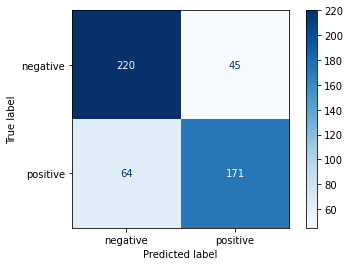

In [96]:
# Test it on the validation data
y_pred = clf.predict(val_bow)

target_names = ['negative', 'positive']
print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()


Let us look at the *features* built by the ```vectorizer```. How can we improve them ? 

<blockquote>We can use the parameters available in CountVectorizer to better select our features. For example:
    <li><i>max_df</i> that ignore terms that have a document frequency strictly higher than the given threshold (if the word is too frequent, it might not be relevant for classification, for ex: prepositions);</li>
    <li><i>min_df</i> which ignores terms that have a document frequency strictly lower than the given threshold (if the word is too rare, that means that it may be specific to the film description, for example the years shown below, and not be helpful in the classification);</li>
    <li><i>max_features</i> as already mentions, define the max number of features;</li>
    <li>also <i>analyzer</i> and <i>ngram_range</i>.</li>
</blockquote>

In [97]:
print(vectorizer.get_feature_names()[:100])

['00', '000', '00001', '007', '0079', '0080', '0083', '01', '02', '05', '06', '07', '08', '09', '10', '100', '1000', '1000000', '100m', '101', '102', '103', '105', '10mil', '10th', '10yr', '11', '110', '1100', '11001001', '112', '12', '120', '1200f', '125', '12s', '12th', '13', '130', '134', '13th', '14', '145', '147', '14ieme', '14th', '15', '150', '16', '161', '16th', '16ème', '17', '1700', '1794', '1798', '18', '180', '1800', '1814', '1824', '1840', '1840s', '1850', '1864', '1880', '1880s', '1892', '1895', '1897', '18th', '19', '1902', '1907', '1910', '1911', '1912', '1914', '1916', '1918', '1920', '1920s', '1921', '1922', '1925', '1927', '1928', '1929', '1930', '1930s', '1931', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s']


### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity. 

**Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with !**

To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 

In [325]:
from sklearn.pipeline import Pipeline

              precision    recall  f1-score   support

    negative       0.76      0.84      0.80       255
    positive       0.81      0.72      0.76       245

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500



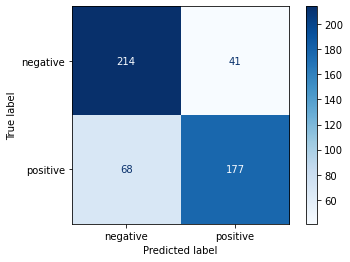

In [324]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline
# This time,  as the pipeline implements the vectorization and Naive Bayes, the fit is with the original reviews.

pipeline_base.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_base.predict(val_texts)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()


              precision    recall  f1-score   support

    negative       0.84      0.82      0.83       265
    positive       0.80      0.82      0.81       235

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



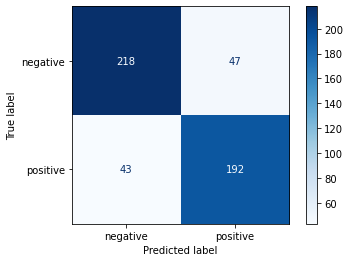

In [99]:
# Fit and test a pipeline with bigrams

pipeline_bigrams = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None,ngram_range=(1,2))),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline

pipeline_bigrams.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_bigrams.predict(val_texts)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()

              precision    recall  f1-score   support

    negative       0.84      0.78      0.81       265
    positive       0.77      0.83      0.80       235

    accuracy                           0.80       500
   macro avg       0.80      0.81      0.80       500
weighted avg       0.81      0.80      0.80       500



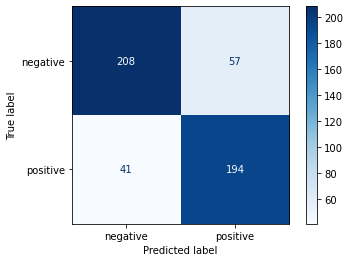

In [100]:
# ... trigrams

pipeline_trigrams = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None,ngram_range=(1,3))),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline

pipeline_trigrams.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_trigrams.predict(val_texts)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()

              precision    recall  f1-score   support

    negative       0.64      0.68      0.66       265
    positive       0.61      0.58      0.60       235

    accuracy                           0.63       500
   macro avg       0.63      0.63      0.63       500
weighted avg       0.63      0.63      0.63       500



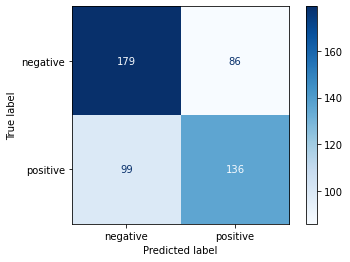

In [101]:
# ... and characters

pipeline_char = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='char', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline

pipeline_char.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_char.predict(val_texts)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()

<blockquote>When the dataset is small, for example with k = 100, the result using monograms, bigrams and trigrams is really similar, having accuracy around 76%-77%. Increasing the size of the dataset (k = 10), results in a better performance for bigrams and trigrams. The results for analyzing characters instead of words is worst than the baseline for all the cases.  </blockquote>

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

In [102]:
from sklearn.feature_extraction.text import TfidfTransformer

              precision    recall  f1-score   support

    negative       0.81      0.86      0.83       265
    positive       0.83      0.77      0.80       235

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



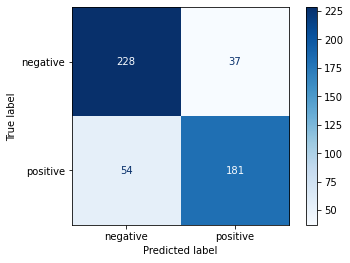

In [104]:
# Fit and test a pipeline with tf-idf

pipeline_tf_idf = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('tfid', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline

pipeline_tf_idf.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_tf_idf.predict(val_texts)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()

<blockquote>As can be seen above, the Tf-idf gives slightly better results, close to the ones obtained using bigrams and trigrams. This might be useful, as words like prepositions are mostly used in all the documents, but don’t add much information to the classification.</blockquote>

### Pre-processing tools: NLTK

We are now going to pre-process our textual data in order to simplify the model's task. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

**Important:** Until now, we obtained representations with ```vectorizer``` applied on the full document. The class divided the string into words itself ! Now, we'll need to do the **tokenization** ourselves in order to apply pre-processing to words. The simplest way to do this is to divide the string following blank spaces, with:
```text.split()```. If we need something more elaborate, we can use a tokenizer from NLTK, ```word_tokenize```.

### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```from nltk import SnowballStemmer```

In [326]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

**Example:**

In [327]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))#.decode('utf-8'))))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

In [137]:
def stem(X): 
    X_stem = []
    for sentence in X:
        words_stem = []
        words = sentence.split()
        # For each word in each document, stem it  
        for word in words:
            words_stem.append(stemmer.stem(word))
        #Rebuilt the review with the stemmed words   
        X_stem.append(' '.join(words_stem))
    return X_stem

              precision    recall  f1-score   support

    negative       0.75      0.85      0.80       241
    positive       0.84      0.73      0.78       259

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



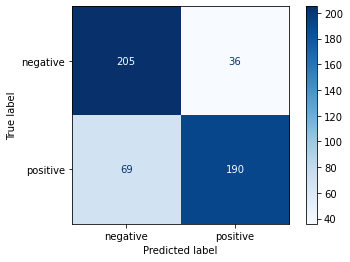

In [145]:
# Transform training and validation data and test it with a basic pipeline
train_stem = stem(train_texts_splt)
val_stem = stem(val_texts)

pipeline_stem = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline

pipeline_stem.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_stem.predict(val_texts)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()


<blockquote>The steaming process doesn’t seem to improve much the results. As can be seen in the example, the stem result for the word “philosophy” is philosophi and for “philosopher” is philosoph, which would still be considered different. Thus, maybe not improving much the results (the steaming still works for extracting the plural for example). </blockquote>

### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```from nltk import pos_tag, word_tokenize```

In [146]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [147]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jutogashi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jutogashi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'ADJ', 'RB']```) for our model.

In [193]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    X_pos = []
    for sentence in X:
        words_stem = []
        words = pos_tag(word_tokenize(sentence))
        words_pos=[]
        # For each word, check if the tag is a good tag   
        for word in words:
            if word[1] in good_tags:
                words_pos.append(word[0])
        #Rebuilt the review with the stemmed words  
        X_pos.append(' '.join(words_pos))
    return X_pos

              precision    recall  f1-score   support

    negative       0.75      0.83      0.79       241
    positive       0.82      0.74      0.78       259

    accuracy                           0.78       500
   macro avg       0.79      0.79      0.78       500
weighted avg       0.79      0.78      0.78       500



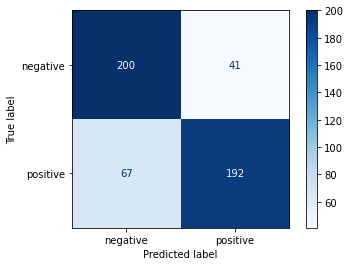

In [196]:
# Transform training and validation data and test it with a basic pipeline
train_pos = pos_tag_filter(train_texts_splt)
val_pos = pos_tag_filter(val_texts)

pipeline_pos = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline

pipeline_pos.fit(train_pos, train_labels_splt)
y_pred = pipeline_pos.predict(val_pos)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()


<blockquote>The speech tag method seems really interesting, as it addresses more directly an issue mention in the Tf-idf applications, that is: some words are used for the construction of the sentences, but don’t add relevant meaning to it and they will be frequent in most documents. The lack of improvement in the results might be due to the fact that some tags that were indeed important for the classifications, were ignored, thus showing us the challenge of determining what is relevant or not for our task.</blockquote>

# Dense Representations 

##  Word Embeddings : Distributed representations via the distributional hypothesis 

**Goal**: We will try to obtain dense representations (as vectors of real numbers) of words (and possibly sentences). These representations are intended to be distributed: they are non-local representations. We represent an object as a combination of *features*, as opposed to the attribution of a dedicated symbol: see the founding work of Geoffrey Hinton, among others, on the subject: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

The term *distributed* representations is very general, but is what we are looking for. The challenge is therefore to be able to build, automatically, such representations.

**Underlying idea**: It is based on the distributional hypothesis: contextual information is sufficient to obtain a viable representation of linguistic objects.
 - For a large class of cases [...] the meaning of a word is its use in the language." Wittgenstein (Philosophical Investigations, 43 - 1953)
 - You shall know a word by the company it keeps, Firth.

Thus, a word can be characterized by the words that accompany it, via co-occurrence counts. Two words with a similar meaning will have a similar contextual distribution and are therefore more likely to appear in similar contexts. This hypothesis can be used as a justification for the application of statistics to semantics (information extraction, semantic analysis). It also allows some form of generalization: we can assume that the information we have about a word will be generalized to words with a similar distribution. 

**Motivation**: The goal is to obtain distributed representations in order to be able to effectively**:
- Directly perform a semantic surface analysis.
- Use it as a source of information for other language-related models and applications, especially for sentiment analysis. 


**Terminology**: Be careful not to confuse the idea of *distributed* and *distributional* representation. The latter generally indicates (for words) that the representation has been obtained strictly from co-occurrence counts, whereas additional information (document labels, part of speech tags, ...) can be used to build distributed representations. 
The models that allow to build these dense representations, in the form of vectors, are often called *vector spaces models*. These representations are also regularly called *word embeddings*, because the words are embedded in a vector space. In French, we often find the term *word embedding* or *lexical embedding*.

## Getting representations: counts of occurrences and co-occurrences

Depending on the type of corpus available, different types of distributional information can be obtained. If we have access to a collection of documents, we can thus choose to count the number of occurrences of each word in each document, to obtain a $words \times documents$ matrix: it is on this principle that **Tf-Idf** is built. We will now look at a more general case: we have a large amount of data in text form, and we want to obtain representations of words in the form of vectors of reduced size, without the need to divide them into documents or categories. 

Suppose we have a corpus containing $T$ different words. We will construct a $\mathbf{M}$ matrix of size $T \times T$ which will contain the number of co-occurrences between words. There will be different factors to consider when constructing this matrix: 

- How do you define the 'context' of a word - context which will tell you what terms co-occur with that word?

We can choose to use different scales: the document, the sentence, the nominal group, or simply a window of $k$ words, depending on the information we want to capture.


- How do we quantify the importance of the counts? 

$\rightarrow$ For example, we can give a decreasing weight to a co-occurrence according to the distance between the two words concerned ($\frac{1}{d+1}$ for a separation by $d$ words).


- Should we keep all the words that appear in the corpus? 

$\rightarrow$ Usually not. We will see that for large corpora, the number $T$ of different words is huge. Second, even if the number of words is reasonable, we will have very little distributional information on the rarest words, and the representation obtained will be of poor quality. We will have to ask ourselves how to filter these words, and how to treat the words we choose not to represent.  

#### Example:

Let's look at the following text:

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

We choose to define the context of a word as the sentence to which it belongs, and to not use any weighting.
We obtain the following matrix: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

### In practice: get a Vocabulary.

To begin, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a maximum number of words, or a minimum number of occurrences to take the words into account. We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary. 

Reminder: use tokenization to obtain words from a document !

In [251]:
def vocabulary(corpus, count_threshold=1, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency        
    """
    word_counts = {}
    # Counting words, if the word is already in dict, increase its count by 1, if not add it to the dict
    for sentence in corpus:
        words = word_tokenize(sentence.lower())
        for word in words:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
     
    # Sorting word count by count values in a decreasing way
    word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1],reverse = True))
    filtered_word_counts = {} 
    # Only consider words that have enough occurrences. 
    # As it’s ordered, we can stop once found a word with not enough occurrences.
    for key, value in word_counts.items():
        if value >= count_threshold:
            filtered_word_counts[key] = value
        else: break
    
             
    vocabulary = {}
    vocabulary_word_counts = {}
    count = 0
    # Getting just the top occurrences words, keeping in the threshold of words in vocabulary  
    for key, value in filtered_word_counts.items():
        # As the default value of voc_threshold is 0, this parameter will only be taken into account if different from 0.
        if (count < voc_threshold) or (voc_threshold == 0):
            vocabulary[key] = count
            vocabulary_word_counts[key] = value
            count += 1
            
    # Adding Unknown value  
    vocabulary['UNK'] = count
    vocabulary_word_counts['UNK'] = 0
    
                            
    return vocabulary, vocabulary_word_counts

In [252]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'i': 5, 'UNK': 0}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### Obtaining co-occurences:

The function takes as input the corpus (a list of strings, corresponding to documents/sentences) and a vocabulary, as well as the size of the context window. We can also implement the simplest solution: the context of a word being the full document to which it belongs. 
Finally, we can implement the possibility of making linearly decrease the importance of the context of a word when getting further from the input word.

In [263]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = word_tokenize(sent.lower())
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = []
        for word in sent:
            if word in vocabulary:
                sent_idx.append(vocabulary[word])
            else:
                sent_idx.append(vocabulary['UNK'])
                
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx_i in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[i+1:i+window+1]
                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[i+1:]
                
            # Go through the list and update M[i,j]:    
            for j, idx_j in enumerate(l_ctx_idx):
                if distance_weighting:
                    weight = 1/(1+j)
                else:
                    weight = 1.0
                M[idx_i, idx_j] += weight 
                M[idx_j, idx_i] += weight 
    return M  

In [264]:
print(co_occurence_matrix(corpus, voc, 0, False))
# Careful: results will differ from the above example because the vocabulary and the order of words are not the same ! 

[[2. 7. 6. 3. 3. 2. 2. 1. 1. 0.]
 [7. 2. 6. 2. 2. 3. 3. 1. 1. 0.]
 [6. 6. 0. 2. 2. 2. 2. 1. 1. 0.]
 [3. 2. 2. 0. 1. 1. 0. 0. 0. 0.]
 [3. 2. 2. 1. 0. 0. 0. 1. 0. 0.]
 [2. 3. 2. 1. 0. 0. 1. 0. 0. 0.]
 [2. 3. 2. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#### Application to a real data set

We're going to work with the **imdb** data.

#### Quick study of the data

We would like to get an idea of what's in these film reviews before we proceed. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

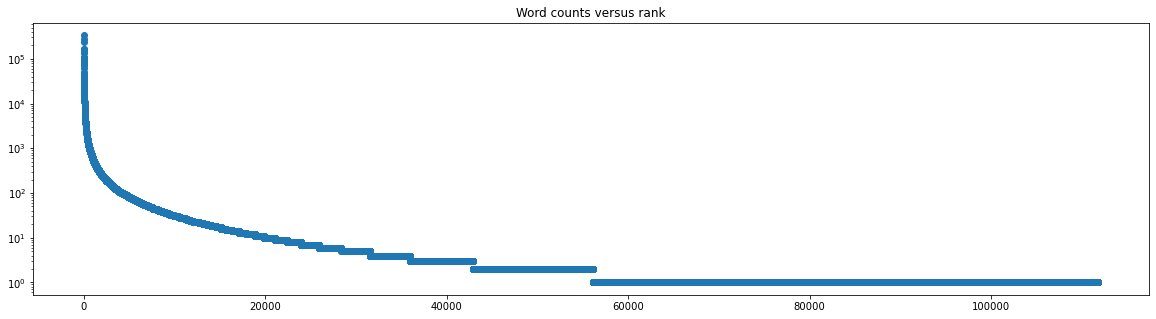

Vocabulary size: 111837
Part of the corpus by taking the "x" most frequent words:
5000 : 0.91
10000 : 0.95
15000 : 0.96
20000 : 0.97
25000 : 0.98
30000 : 0.98
35000 : 0.98
40000 : 0.99
45000 : 0.99
50000 : 0.99
55000 : 0.99
60000 : 0.99
65000 : 0.99
70000 : 0.99
75000 : 0.99
80000 : 1.00
85000 : 1.00
90000 : 1.00
95000 : 1.00
100000 : 1.00
105000 : 1.00
110000 : 1.00


In [256]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts)
rank_counts = {w:[vocab[w], word_counts[w]] for w in vocab}
rank_counts_array = np.array(list(rank_counts.values()))

plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1])
plt.yscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(5000, len(vocab), 5000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

**Result of the analysis**: we can be satisfied with a vocabulary of 10,000 or even 5,000 words - this is important, because it will determine the size of the objects we will manipulate. 

In [257]:
vocab_5k, word_counts_5k = vocabulary(train_texts, 0, 5000)

In [258]:
print(vocab_5k['cinema'])

448


In [259]:
M5dist = co_occurence_matrix(train_texts, vocab_5k, window=5, distance_weighting=True)
M20 = co_occurence_matrix(train_texts, vocab_5k, window=20, distance_weighting=False)
print(M5dist.shape)
print(M20.shape)

(5001, 5001)
(5001, 5001)


<blockquote>As can be seen in the graph above the occurrence of the words indeed follow a Zipf’s Law. The “steps” that can be seen in the tail of the graph are due to the fact that the count is a discreet number and we have steps in the log scale in lower counts (for example going from 1 count to 2, 2 to 3). It’s shown that a small vocabulary of even 5000 words can represent 90% of the data. <br><br>At last, the size of the co-occurrence matrixes is equal to 5001 because the vocabulary is equal to 5000 and we have the extra Unknown value.
</blockquote>

### Vector comparison 

We can use these very large-dimensional vectors for a very simple semantic analysis: for example, by looking for the nearest neighbors of a words. However, we need to be careful to the distance that we use (euclidean, cosine). Vector normalization can also play a role; in any way, we need to not over-interpret this type of results. 

In [260]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print("With a large context, without taking in account distance between words:")    
print_neighbors(euclidean, vocab_5k, M20, 'good')
print_neighbors(cosine, vocab_5k, M20, 'good')
print("")
print("With a small context, and reducing the impact of counts when words are distant:")    
print_neighbors(euclidean, vocab_5k, M5dist, 'good')
print_neighbors(cosine, vocab_5k, M5dist, 'good') 

With a large context, without taking in account distance between words:
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'even', 'more', 'what', 'no', 'would', 'story', 'only', 'can']]
Plus proches voisins de good selon la distance 'cosine': 
[['decent', 'great', 'very', 'pretty', 'not', 'nice', 'funny', 'entertaining', 'really']]

With a small context, and reducing the impact of counts when words are distant:
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'great', 'bad', 'just', 'also', 'really', 'even', 'what', 'little']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'fine', 'wonderful', 'simple', 'nice', 'decent', 'serious', 'promising', 'joke']]


<blockquote>Overall, giving the previous example for the word ‘good’, the Euclidian distance seems to give results that are usually used with the word good, for example ‘very good’. The cosine distance results are closest to synonyms of the word good, that is, words that are used in the same context. The results seem to be more coherent for a smaller window in that case.</blockquote>

## Modifying the representations:

We may want to alter the representations to obtain better features - depending on what use we will have for them.

**Normalization**: Very easy: we want to cancel the influence of the magnitude of the counts on the representation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: The aim is to assess the extent to which the co-occurrence of the two terms is *unexpected*. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
The joint probability of the two words corresponds to the number of times they are observed together, divided by the total number of co-occurrences in the corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
The individual probability of a word simply corresponds to its frequency, which can be calculated by counting all co-occurrences where that word appears:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Hence,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
We thus calculate the discrepancy between the observation we have made in our corpus and the frequency of appearance of these terms if we consider them independent - i.e. we assume that their co-occurrence is a coincidence.

The main problem with this measure is that it is not adapted to the case where no co-occurrence is observed. Since the PMI is supposed to return a positive quantity if more co-occurrences are observed than expected, and a negative quantity if fewer co-occurrences are observed, we cannot choose to replace $\log(0)$ by $0$. A commonly used solution is to use the **Positive PMI**, which sets all negative values to $0$.
 
 $$ \text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases} $$

In [266]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))                   
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

In [267]:
PPMI5 = pmi(M5dist)
PPMI20 = pmi(M20)

print("Avec la PPMI:")    
print_neighbors(euclidean, vocab_5k, PPMI5, 'good')
print_neighbors(cosine, vocab_5k, PPMI5, 'good')
print_neighbors(euclidean, vocab_5k, PPMI20, 'good')
print_neighbors(cosine, vocab_5k, PPMI20, 'good')

Avec la PPMI:
Plus proches voisins de good selon la distance 'euclidean': 
[['/', '>', 'bad', 'br', 'but', 'there', 'think', '.', 'good.']]
Plus proches voisins de good selon la distance 'cosine': 
[['bad', 'great', 'decent', 'excellent', 'nice', 'fine', 'interesting', 'funny', 'poor']]
Plus proches voisins de good selon la distance 'euclidean': 
[['.', 'but', ',', 'is', 'it', 'and', 'movie', 'the', 'this']]
Plus proches voisins de good selon la distance 'cosine': 
[['.', 'great', 'decent', 'bad', 'pretty', 'acting', 'but', 'excellent', 'very']]


<blockquote>The results follow the same logic as before: the Euclidean distance returns words that are often used together, while the cosine words that have similar use. The results now seem more diverse, as expected to using a measure of ‘unexpectance’ than the count, now having results such as ‘bad’, ‘decent’ or ‘poor’.</blockquote>

### Co-occurences matrix: reducing the dimension

#### Motivation

The goal is not only to reduce the size of the data representation (then, we will work with smaller pre-determined sized representations, instead of working with vectors of the size of the vocabulary) but also showcase higher-level relationships between words: by reducing their representations to the *most important dimensions* of the data, we end up *generalizing* some properties of words.

#### Dimension reduction via SVD 

A matrix is a linear transformation: applying a SVD to it is decomposing our linear transformation in a product of linear transformations of different types. We are changing the basis and replacing our data in a different space, using **eigenvectors**:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Matrices $\mathbf{U}$, $\mathbf{\lambda}$, and $\mathbf{V}$ have the following properties:
- $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ and $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). They contain the eingenvectors to the left and to the right of $\mathbf{M}$.
- $\mathbf{\lambda}$ is a diagonal matrix: careful, it is not necessarily square. diagonal coefficient are the eigenvalues of $\mathbf{M}$.

Then, the *most important dimensions* correspond to the highest eigenvalues. Reducing our data to a dimension $k$ corresponds to only keeping vectors corresponding to the $k$ first eigenvalues - which in turns is equivalent to keeping only the first $k$ vectors of $U$. 
We use ```TruncatedSVD``` from ```scikit-learn```:

In [268]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M5dist)
print(SVDEmbeddings.shape)
SVDEmbeddings[vocab_5k['UNK']]

print_neighbors(euclidean, vocab_5k, SVDEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, SVDEmbeddings, 'good')

(5001, 300)
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'great', 'bad', 'just', 'also', 'really', 'even', 'what', 'little']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'fine', 'wonderful', 'pleasant', 'simple', 'promising', 'lousy', 'nice', 'decent']]


Note: When applying this method to the count matrix $\mathbf{M}$ of dimension $T \times D$, where $\mathbf{M}_{t,d}$ contains the number of occuerences of the word $t$ in the document $d$, we obtain the method called **Latent Semantic Analysis**, which is used to detect latent (semantic) components allowing to group documents together.

<blockquote>The results follow again the same logic, but they seem of even higher quality than with PMI. We also need to consider the fact that we are able to obtain they with a smaller matrix, thus a smaller processing time, which in the presence of really huge amount of data is desirable. </blockquote>

#### Visualization in two dimensions

We will now use **principal components analysis** (PCA) to visualize our data in two dimensions. This is equivalent to applying SVD to the covariance matrix of the data, in order for the principal components to be independant from each other an maximize the variance of the data. We use the class ```PCA``` from ```scikit-learn```: 

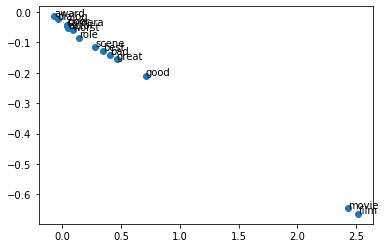

In [271]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(M5dist)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

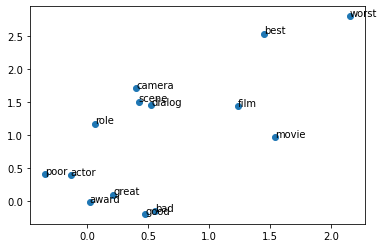

In [270]:
Norm5 = M5dist / np.linalg.norm(M5dist, ord=2, axis=1, keepdims=True)

pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(Norm5)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

<blockquote>The objective of the PCA is to project our data into a smaller space, in a way of maximizing its variance, that way synthesizing the data with the minimal lost of information. This is a useful method, as in a smaller space we can visualize the proximity between observations and the correlation between variables.<br><br>
Without the normalization, in the first graph, it’s hard to have any conclusions. However, in the second graph, we can observe relations between the different words, for example: “camera”, “scene” and “dialog”, that can be used in similar context while describing the technicalities of a movie; also the proximity of “good”/”bad” or “best”/”worst”.  
</blockquote>

## Getting a representation: commonly used algorithms

The idea here is to define a set of representations ${w_{i}}_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want. 

### Word2Vec


####  The skip-gram model

The basic skip-gram model estimates the probabilities of a pair of words $(i, j)$ to appear together in data:

$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


where $w_{i}$ is the lign vector (of the word) $i$ and $c_{j}$ is the column vector (of a context word) $j$. The objective is to minimize the following quantity:


$$ -\sum_{i=1}^{m} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


where $V$ is the vocabulary.
The inputs $w_{i}$ are the representations of the words, which are updated during training, and the output is an *one-hot* $o$ vector, which contains only one $1$ and $0$. For example, if `good` is the 47th word in the vocabulary, the output $o$ for an example or `good` is the word to predict will consist of $0$s everywhere except $1$ in the 47th position of the vector. `good` will be the word to predict when the input $w$ is a word in its context.
We therefore obtain this output with standard softmax - we add a bias term $b$ .


$$ o = \textbf{softmax}(w_{a}C + b)$$


If we use the set of representations for the whole vocabulary (the matrix $W$) as input, we get:


$$ O = \textbf{softmax}(WC + b)$$


and so we come back to the central idea of all our methods: we seek to obtain word representations from co-occurrence counts. Here, we train the parameters contained in $W$ and $C$, two matrices representing the words in reduced dimension (300) so that their scalar product is as close as possible to the co-occurrences observed in the data, using a maximum likelihood objective.

#### Skip-gram with negative sampling

The training of the skip-gram model implies to calculate a sum on the whole vocabulary, because of the **softmax**. As soon as the size of the vocabulary increases, it becomes impossible to compute. In order to make the calculations faster, we change the objective and use the method of *negative sampling* (or, very close to it, the *noise contrastive estimation*).


If we note $\mathcal{D}$ the data set and we note $\mathcal{D}'$ a set of pairs of words that are **not** in the data (and that in practice, we draw randomly), the objective is:


$$\sum_{i, j \in \mathcal{D}}-\log\sigma(w_{i}c_{j}) + \sum_{i, j \in \mathcal{D}'}\log\sigma(w_{i}c_{j})$$


where $\sigma$ is the sigmoid activation function $\frac{1}{1 + \exp(-x)}$.
A common practice is to generate pairs from $\mathcal{D}'$ in proportion to the frequencies of the words in the training data (the so-called unigram distribution):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Although different, this new objective function is a sufficient approximation of the previous one, and is based on the same principle. Much research has been done on this objective: for example, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) shows that the objective calculates the PMI matrix shifted by a constant value. One can also see [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) for an interpretation of the algorithm as a variant of PCA.

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above. 
To avoid having to put all the data in memory all at once, we define a generator, which will take all the input data and pre-process it, and return to the ```Word2Vec``` class sentence by sentence. 

In [280]:
from gensim.models import Word2Vec

model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts_5k))
model.build_vocab_from_freq(word_counts_5k)

In [281]:
preprocessed_corpus = [word_tokenize(train_texts[i]) for i in range(len(train_texts))]

In [282]:
model.train(preprocessed_corpus, total_examples=len(train_texts), epochs=20, report_delay=1)

(77031969, 141306660)

In [283]:
W2VEmbeddings = model.wv.vectors

### Glove

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data.

The following code uses the gensim API to retrieve pre-trained representations (It is normal that the loading is long).

In [286]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [287]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [288]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [289]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In order to compare the representations loaded here and the ones produced with word2vec, the same vocabulary should be used. For this purpose, I reuse the following code to create a $5000$ word vocabulary from the data, and I add at the end a function that returns the matrix of representations loaded with Glove for these $5000$ words only, in the right order. 

In [290]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [291]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.
Note: unknown words are represented by a vector of zeros:

In [292]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

(5001, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Application to sentiment analysis

We will now use these representations for sentiment analysis. 
The basic model, as before, will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```  

In [309]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = np.zeros((len(texts), embeddings.shape[1]))
    for i in range(len(texts)):
        words = word_tokenize(texts[i].lower())
        emb_words = np.zeros((len(words), embeddings.shape[1]))
        for j in range(len(words)):
            # If the word is in the vocabulary, we will add its embedding
            # Otherwise, it’s unknown, as embedding of UNK is zeros, we skip
            if words[j] in vocabulary:
                index = vocabulary[words[j]]
                emb_words[j] = embeddings[index,:]
                
        # The representation of the sentence is equal to the operation applied to the embeddings of all words in it.
        representations[i,:] = np_func(emb_words, axis=0)
    
    return representations

In [310]:
train_rep = sentence_representations(train_texts_splt, vocab_5k, GloveEmbeddings)
val_rep = sentence_representations(val_texts, vocab_5k, GloveEmbeddings)

In [311]:
from sklearn.linear_model import LogisticRegression

C:\Users\jutogashi\anaconda3\envs\p38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       241
    positive       0.81      0.83      0.82       259

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



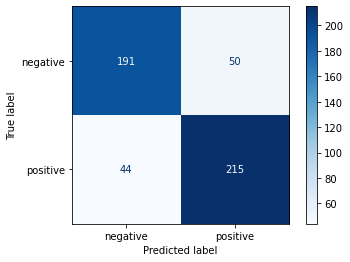

In [313]:
# Fit the classifier on the transformed training data and test it on the transformed validation data
clf = LogisticRegression().fit(train_rep, train_labels_splt)
y_pred = clf.predict(val_rep)

print(classification_report(val_labels, y_pred, target_names=target_names))

cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap = 'Blues')
plt.show()

You can know compare the various sets of embeddings, and answer the following questions:
- Why could we expect that the results obtained with embeddings pre-trained with Glove are better than others ? Is that verified ? And what changes if we remove the constraint of having the same 5000 words vocabulary as the other methods ? 
- Which matrix that we can reduce the dimension of gives the best results ? 

<blockquote>We could expect that the results using Glove would be better because the embedding should be able to represent stronger connections between words than simply their co-occurrences in the sentences.<br><br> However, the results obtained aren’t better, this can be due to the fact that firstly, we aren’t working with a large dataset, and maybe more data was needed for a proper training. Secondly, we used the constraint of 5000 words. With that constraint, most of the words of our documents (over 95000) will be considered unknown, and won’t add to the embedding representation of our sentence.<br><br> Therefore, it might be concluded that it’s more interest to use more words, which comes with the price of memory usage and processing time.<br><br> The best overall results were obtained using BoW with bigrams and the Tf-idf. We can reduce the size of the matrix by combining it with the pre-processing methods, thus selecting a more relevant space of Vocabulary.</blockquote>